In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 05b Toy Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05b Toy Dataset Benchmarker.ipynb"
dataset_name = "double helix"
sigma = "automatic"
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 20
diffdist_weight = 10
num_neighbors = 5

# Set Up

Set sigma =  0.085062236


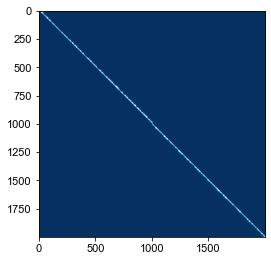

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
# choose correct dataset
if dataset_name == "double helix":
    X, flow, labels = double_helix(num_nodes=2000)
elif dataset_name == "noisy double helix":
    X, flow, labels = double_helix(num_nodes=2000, noise=0.5)
elif dataset_name == "branch":
    X, flow, labels = directed_sinh_branch(num_nodes=2000)
    
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

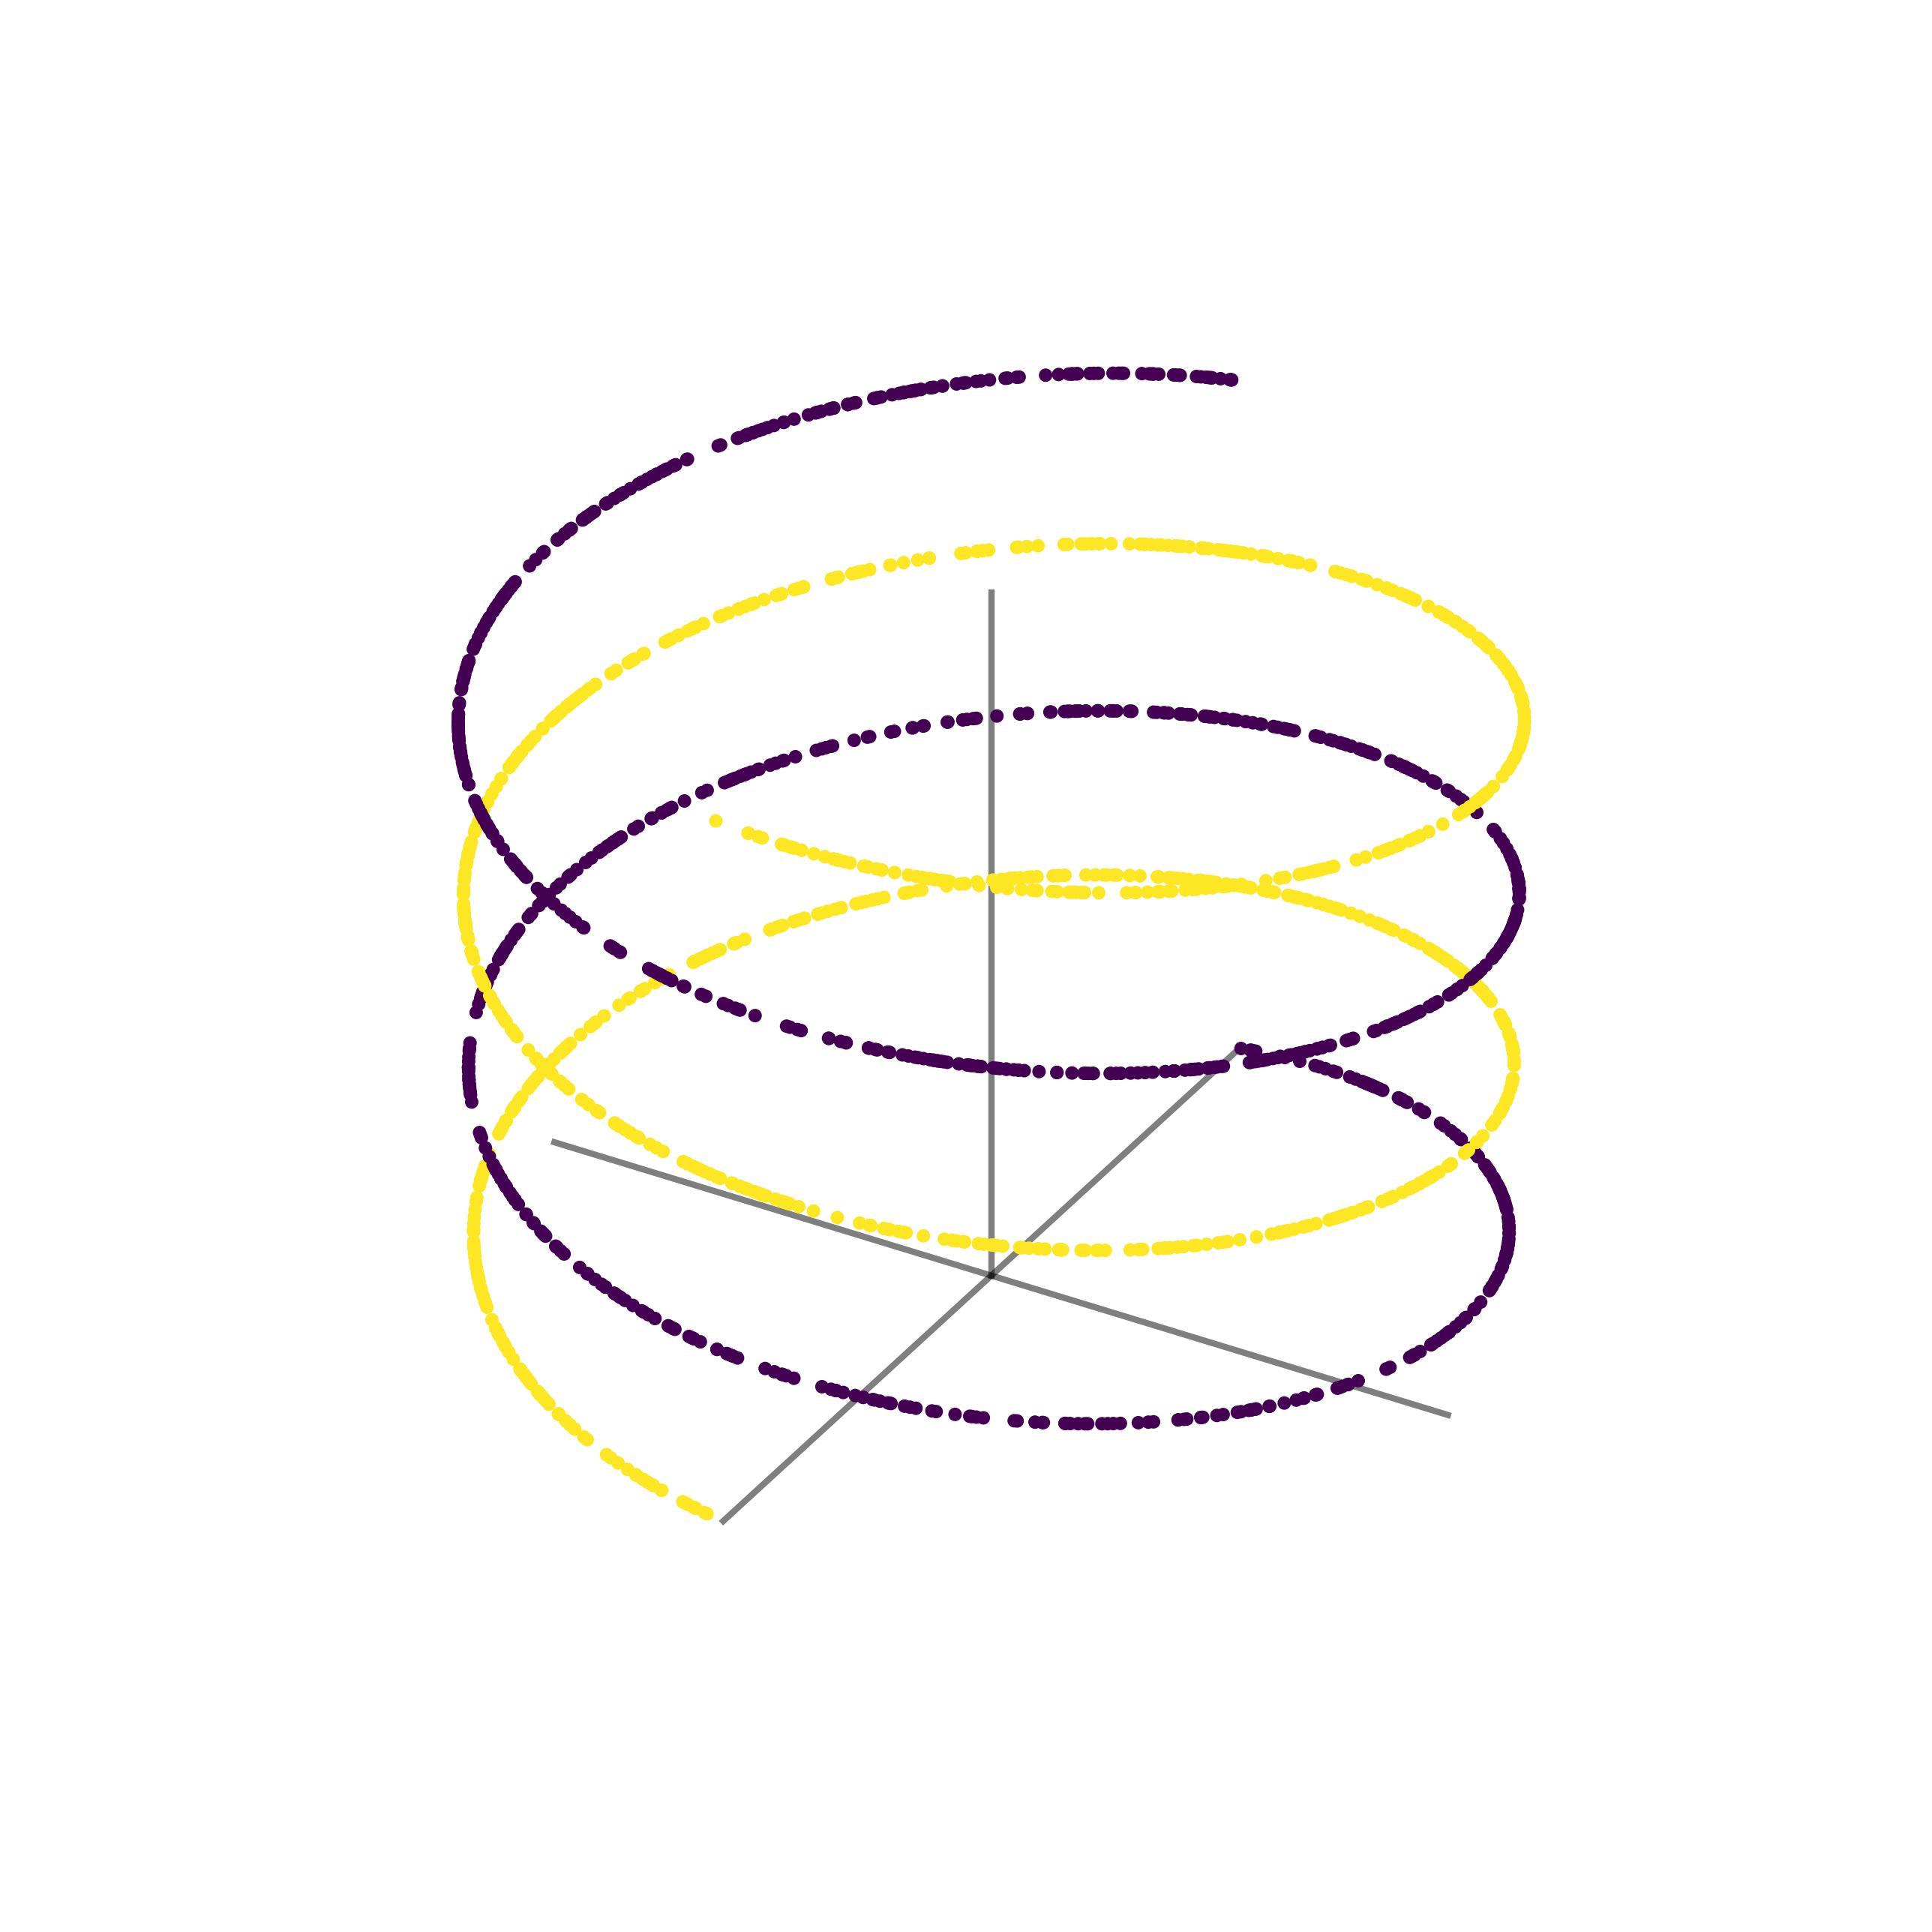

In [ ]:
# visualize figure
from FRED.datasets import plot_origin_3d
mask_prob = 1
num_nodes = X.shape[0]
alpha_points, alpha_arrows = (0.1, 1) if labels is None else (1, 0.1)
mask = np.random.rand(num_nodes) > mask_prob
fig = plt.figure(dpi=400, figsize=(8,8))
ax = fig.add_subplot(projection="3d",)
plot_origin_3d(
    ax,
    xlim=[X[:, 0].min(), X[:, 0].max()],
    ylim=[X[:, 1].min(), X[:, 1].max()],
    zlim=[X[:, 2].min(), X[:, 2].max()],
    )
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker=".", c=labels, cmap="viridis", alpha=alpha_points)
ax.quiver(
    X[mask, 0],
    X[mask, 1],
    X[mask, 2],
    flow[mask, 0],
    flow[mask, 1],
    flow[mask, 2],
    alpha=0.4,
    length=0.4,
    normalize=False,
)
ax.axis('off')
# ax.grid(False)
# lim = np.max(np.linalg.norm(X, axis=1))
# print("lim is",lim)
# ax.axes.set_xlim3d(left=-lim, right=lim)
# ax.axes.set_ylim3d(bottom=-lim, top=lim)
# ax.axes.set_zlim3d(bottom=-lim, top=lim)
plt.show()

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=1,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
        }
visualization_functions = [
    visualize_points,
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

  0%|          | 0/10 [00:00<?, ?it/s]

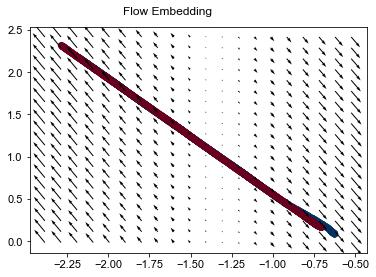

 10%|█         | 1/10 [00:05<00:53,  5.97s/it]

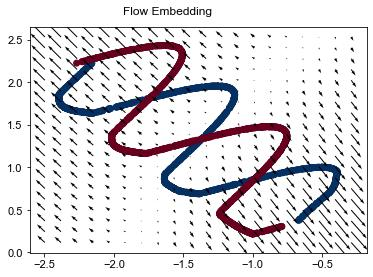

 20%|██        | 2/10 [00:10<00:38,  4.87s/it]

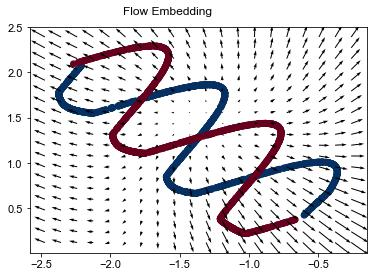

 30%|███       | 3/10 [00:14<00:32,  4.68s/it]

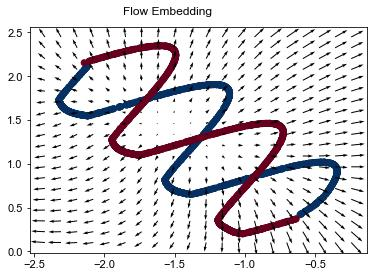

 40%|████      | 4/10 [00:18<00:26,  4.38s/it]

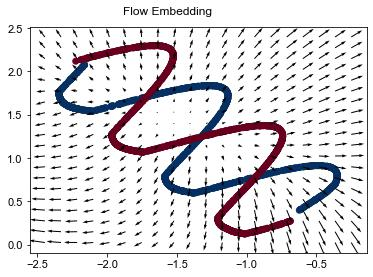

 50%|█████     | 5/10 [00:22<00:21,  4.22s/it]

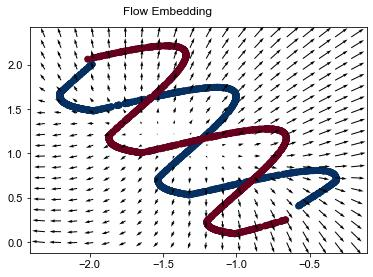

 60%|██████    | 6/10 [00:26<00:16,  4.11s/it]

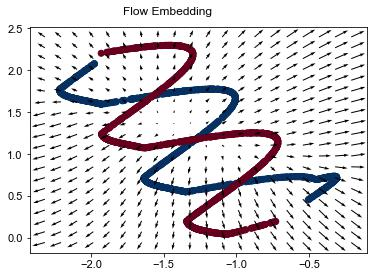

 70%|███████   | 7/10 [00:30<00:12,  4.05s/it]

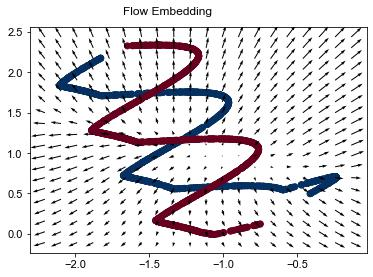

 80%|████████  | 8/10 [00:34<00:08,  4.02s/it]

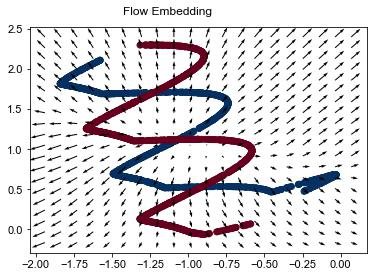

 90%|█████████ | 9/10 [00:38<00:03,  3.99s/it]

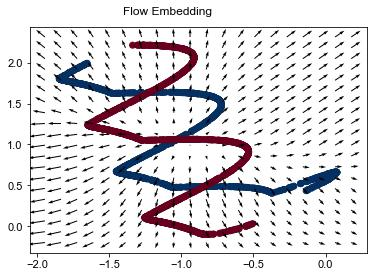

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=10)

# Results

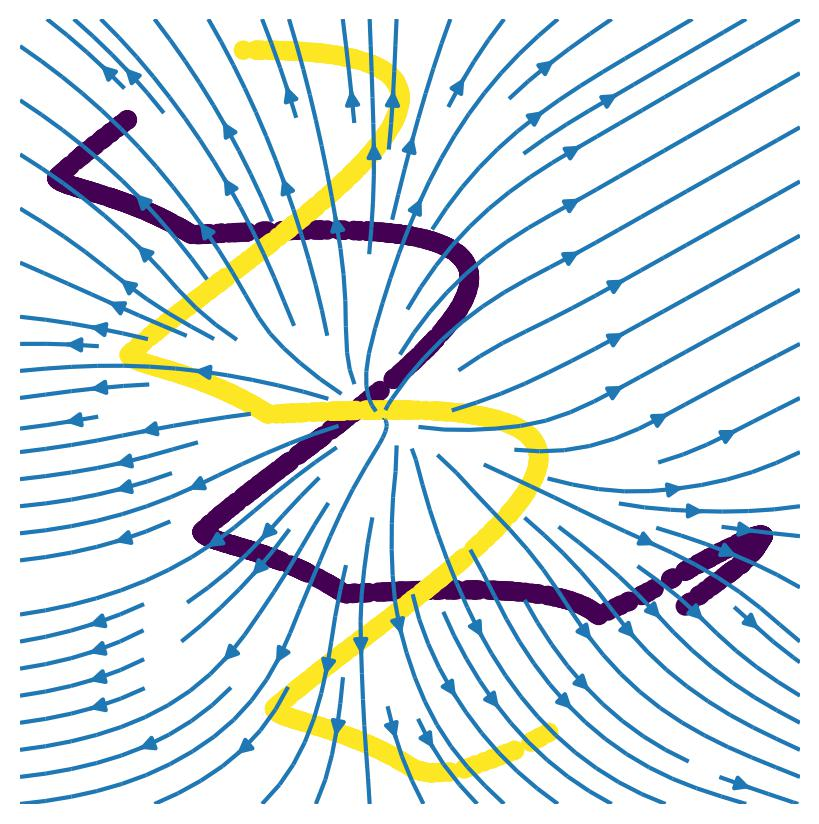

In [ ]:
FREDtrainer.visualize_embedding()

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
flow_artist = FREDtrainer.flow_artist

In [ ]:
# from FRED import embed
# from FRED.trainers import visualize_points
# visualize_points(FREDtrainer.embedded_points.cpu().detach(), FREDtrainer.flow_artist, labels = labels, use_streamlines=True)

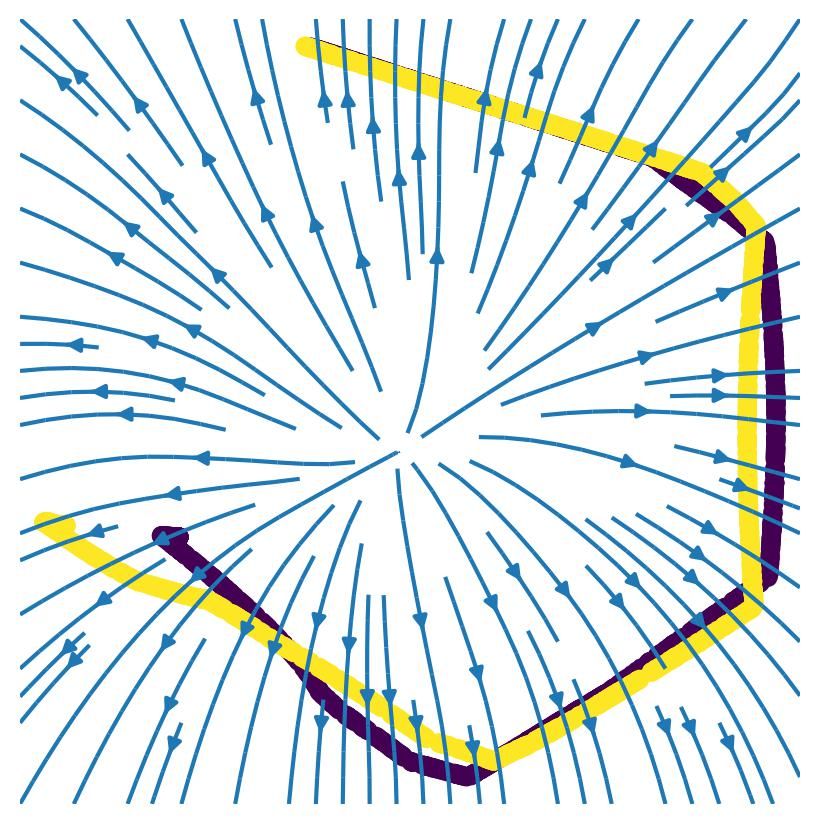

In [ ]:
from FRED.embed import compute_grid
fig = plt.figure(dpi=200, figsize=(5,5))
ax = fig.add_subplot()
grid_width = 100
minx = float(np.min(embedded_points[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(embedded_points[:, 0]) + 0.1)
miny = float(np.min(embedded_points[:, 1]) - 0.1)
maxy = float(np.max(embedded_points[:, 1]) + 0.1)
x = np.linspace(minx, maxx, grid_width)
y = np.linspace(miny, maxy, grid_width)
# build grid points
Xgrid, Ygrid = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(Xgrid[:,:,None]), torch.tensor(Ygrid[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# pass grid through flow artist
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu()
v = uv[:,:, 1].cpu()
sc = ax.scatter(
    embedded_points[:, 0],
    embedded_points[:, 1],
    c=labels, cmap='viridis'
)
ax.streamplot(x,y,u,v)
plt.axis("off")
# Display all open figures.
plt.show()
plt.close()

In [ ]:
embedded_points[:, 1]

array([-1.0280571, -1.0282054, -1.0282204, ...,  0.7693091,  0.7697907,
        0.7707847], dtype=float32)

In [ ]:
X.shape

(2000, 3)

In [ ]:
from FRED.embed import compute_grid
import plotly.figure_factory as ff
import numpy as np
import plotly.graph_objects as go
grid_width=200
# grid, x, y = compute_grid(embedded_points.to(device), return_unmeshed_x_and_y=True, grid_width=100)
minx = float(np.min(X[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(X[:, 0]) + 0.1)
miny = float(np.min(X[:, 1]) - 0.1)
maxy = float(np.max(X[:, 1]) + 0.1)
x = np.linspace(-minx, maxx, grid_width)
y = np.linspace(-miny, maxy, grid_width)
X, Y = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(X[:,:,None]), torch.tensor(Y[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# controls the x and y axes of the plot
# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
# u = -1 - grid[:,0]**2 + grid[:,1]
# v = 1 + grid[:,0] - grid[:,1]**2
# u = -1 - X**2 + Y
# v = 1 + X - Y**2
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu().numpy()
v = uv[:,:, 1].cpu().numpy()
# x = x.numpy()
# y = y.numpy()
# u = u.numpy()
# v = v.numpy()

In [ ]:
uv[:,:,0]

tensor([[0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
        [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
        [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
        ...,
        [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
        [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
        [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394]])

In [ ]:
v

array([[0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412],
       [0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412],
       [0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412],
       ...,
       [0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412],
       [0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412],
       [0.04756412, 0.04756412, 0.04756412, ..., 0.04756412, 0.04756412,
        0.04756412]], dtype=float32)

In [ ]:
grid

tensor([[-0.9982, -3.5243],
        [-0.9982, -3.5030],
        [-0.9982, -3.4817],
        ...,
        [ 1.2761, -1.4579],
        [ 1.2761, -1.4366],
        [ 1.2761, -1.4153]])

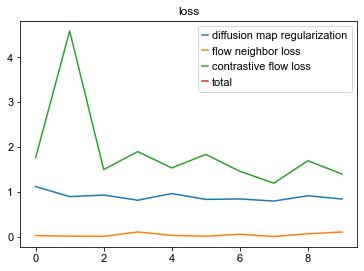

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhhANYAocAAP///////f//+f7///z///v///n///z//Pj///f///X///b/+/…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(2000, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: 0.004682721104472876.
 silhouette score w/ flows:  0.004682727158069611 
 kNN Classifier 0.8606060606060606


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'A7xsiXkGnDoVbtfHzP39'

In [ ]:
import csv
spread_name = notebook
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         flow_strength, 
         flow_neighbor_loss_weight,
         smoothness_weight, 
         diffdist_weight, 
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 